In [1]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Metrics evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

#FT-Distilled BERT
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from numpy import argmax

### 1) Import Dataset

In [3]:
review_df = pd.read_csv('full_dataset_file_path')

In [4]:
review_df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

In [5]:
review_df['Processed Reviews'] = review_df['Processed Reviews'].astype(str)

### 2) Vader sentiment analysis

In [6]:
sia = SentimentIntensityAnalyzer()

In [7]:
#Run the polarity score on the entire dataset
result = {}
for i, row in tqdm(review_df.iterrows(), total = len(review_df)):
    text = row['Processed Reviews']
    myid = row['id']
    result[myid] = sia.polarity_scores(text)

  0%|          | 0/455533 [00:00<?, ?it/s]

In [8]:
vaders = pd.DataFrame(result).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(review_df, how='left')
#Sentiment score and meta data
vaders.head()

,id,neg,neu,pos,compound,product name,brand,product link,retail_price ($),offer_price ($),...,ingredients,product_type,Product Category,Product,Customer Name,Date of Review,Country,Review,Rating,Processed Reviews
0,0,0.0,1.000,0.000,0.0000,Original Cleansing Face Wipes,SEPHORA COLLECTION,https://www.sephora.sg/products/sephora-collec...,14.0,9.8,...,"Coconut: Aqua (Water), Glycerin, Polyglyceryl-...",cleanser-and-exfoliator,NaN,Original Cleansing Face Wipes • 20 wipes,Kerish Albano,13 Jun 2023,Australia,coconut wipe It does remove my makeup but had ...,3.5,coconut wipe remove makeup 2 wipe
1,1,0.0,0.656,0.344,0.2732,Original Cleansing Face Wipes,SEPHORA COLLECTION,https://www.sephora.sg/products/sephora-collec...,14.0,9.8,...,"Coconut: Aqua (Water), Glycerin, Polyglyceryl-...",cleanser-and-exfoliator,NaN,Original Cleansing Face Wipes • 20 wipes,Seeya Nair,13 Jun 2023,Malaysia,works so well 1 tissues cleanse all my makeup,5.0,work well 1 tissue cleanse makeup
2,2,0.0,0.649,0.351,0.4019,Original Cleansing Face Wipes,SEPHORA COLLECTION,https://www.sephora.sg/products/sephora-collec...,14.0,9.8,...,"Coconut: Aqua (Water), Glycerin, Polyglyceryl-...",cleanser-and-exfoliator,NaN,Original Cleansing Face Wipes • 20 wipes,Mable lee,12 Jun 2023,Malaysia,face wipes Makeup remover is very clean and mo...,4.0,face wipe makeup remover clean moisturizing
3,3,0.0,0.297,0.703,0.7964,Original Cleansing Face Wipes,SEPHORA COLLECTION,https://www.sephora.sg/products/sephora-collec...,14.0,9.8,...,"Coconut: Aqua (Water), Glycerin, Polyglyceryl-...",cleanser-and-exfoliator,NaN,Original Cleansing Face Wipes • 20 wipes,Gugu Mutema,08 Jun 2023,Australia,Mrs Love these. They took my makeup off nicely,5.0,mr love took makeup nicely
4,4,0.0,0.206,0.794,0.7717,Original Cleansing Face Wipes,SEPHORA COLLECTION,https://www.sephora.sg/products/sephora-collec...,14.0,9.8,...,"Coconut: Aqua (Water), Glycerin, Polyglyceryl-...",cleanser-and-exfoliator,NaN,Original Cleansing Face Wipes • 20 wipes,Naima Ali,06 Jun 2023,Australia,"Cleans well :) It's gentle on the skin, does t...",5.0,clean well gentle skin job


In [9]:
def vaders_sentiment(compound):
    if compound < 0.4:
        return 'negative'
    elif compound > 0.6:
        return 'positive'
    else:
        return 'neutral'

def sentiment_classified(score):
    if score >= 4:
        return 'positive'
    elif score <=2:
        return 'negative'
    else:
        return 'neutral'

In [10]:
vaders['predicted_vaders_rating'] = vaders['compound'].apply(vaders_sentiment)
vaders['actual_rating'] = vaders['Rating'].apply(sentiment_classified)
vaders2 = vaders[['neg', 'neu', 'pos', 'Product', 'Customer Name', 'Date of Review', 'Country', 'Review', 'Rating', 'predicted_vaders_rating', 'actual_rating']]

### 3) Vaders Evaluation

In [35]:
y_true = vaders2['actual_rating']
y_pred = vaders2['predicted_vaders_rating']

#Encode labels to numbers
label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_true)
y_pred_encoded = label_encoder.transform(y_pred)



# Calculate the confusion matrix
cm = confusion_matrix(y_true_encoded, y_pred_encoded, normalize='true')
cm2 = confusion_matrix(y_true_encoded, y_pred_encoded)

# Get the class labels
class_labels = label_encoder.classes_

#Classification report
cr = classification_report(y_true_encoded, y_pred_encoded)

In [36]:
print(cr)

              precision    recall  f1-score   support

           0       0.35      0.49      0.41     42855
           1       0.15      0.12      0.13     40290
           2       0.88      0.86      0.87    372388

    accuracy                           0.76    455533
   macro avg       0.46      0.49      0.47    455533
weighted avg       0.77      0.76      0.76    455533



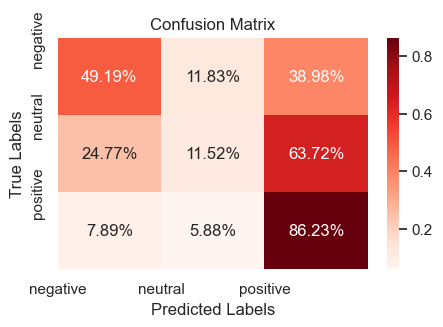

In [25]:
# Plot the confusion matrix using heatmap
sns.set(font_scale=1)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Reds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=range(len(class_labels)), labels=class_labels)
plt.yticks(ticks=range(len(class_labels)), labels=class_labels)
plt.title('Confusion Matrix')
plt.show()

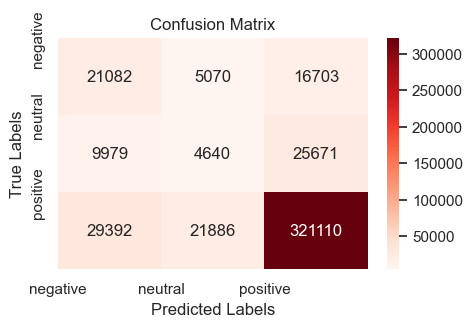

In [12]:
# Plot the confusion matrix using heatmap with count values
plt.figure(figsize=(5, 3))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=range(len(class_labels)), labels=class_labels)
plt.yticks(ticks=range(len(class_labels)), labels=class_labels)
plt.title('Confusion Matrix')
plt.show()

In [26]:
# Calculate accuracy
accuracy = accuracy_score(y_true_encoded, y_pred_encoded)
# Calculate precision
precision = precision_score(y_true_encoded, y_pred_encoded, average='weighted')
# Calculate recall
recall = recall_score(y_true_encoded, y_pred_encoded, average='weighted')
# Calculate F1-score
f1 = f1_score(y_true_encoded, y_pred_encoded, average='weighted')


print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}") #correctly predicted positive/all positive
print(f"Recall: {recall:.2f}") # sensitivity
print(f"f1 score: {f1:.2f}")

Accuracy: 0.76
Precision: 0.77
Recall: 0.76
f1 score: 0.76


### VADER Actual and Predicted Review Analysis
predicted negative and actual positive

In [17]:
vaders2[(vaders2['predicted_vaders_rating'] == 'negative') & (vaders2['actual_rating'] == 'positive')]['Review'].tolist()

['works so well 1 tissues cleanse all my makeup',
 'affordable and works very affordable for more than 10 pieces of wipes! it works decently and the fragrance is not overwhelming for me too.',
 "Best wipes! I bought these to try and wasn't disappointed. They smelt amazing and actually took off all my makeup. The only downside is they are a little pricey for 25 wipes.",
 'smell so good Smells sooo goood , it wipes off completely for when your lazy',
 'face wipe good for lazy nights for a quick cleanse',
 "does the job! they did the job but dried out really quickly and broke me out a little! might be better for someone who doesn't have any skin sensitivities",
 'Vishalene When stocking up on wet wipes, the coconut, aloe and watermelon are my favs.',
 "Ms I've tried all flavours of Sephora Wet Wipes. The coconut, aloe and watermelon are my favs.",
 'not bad Perfect for lazy people . However , this doesn’t work too well for waterproof make up',
 'Sephora Collection Original Cleansing Face 

### 4) Fine-Tuned DistilBERT Evaluation

In [39]:
sdf = pd.read_csv('ft_bert_file_path')

In [3]:
sdf.head()

,id,predicted score,Product,Customer Name,Date of Review,Country,Review,Product URL,Rating,predicted sentiment,actual sentiment
0,0,4,Original Cleansing Face Wipes • 20 wipes,Kerish Albano,13-Jun-23,Australia,coconut wipe It does remove my makeup but had ...,https://www.sephora.sg/products/sephora-collec...,3.5,positive,neutral
1,1,5,Original Cleansing Face Wipes • 20 wipes,Seeya Nair,13-Jun-23,Malaysia,works so well 1 tissues cleanse all my makeup,https://www.sephora.sg/products/sephora-collec...,5.0,positive,positive
2,2,5,Original Cleansing Face Wipes • 20 wipes,Mable lee,12-Jun-23,Malaysia,face wipes Makeup remover is very clean and mo...,https://www.sephora.sg/products/sephora-collec...,4.0,positive,positive
3,3,5,Original Cleansing Face Wipes • 20 wipes,Gugu Mutema,8-Jun-23,Australia,Mrs Love these. They took my makeup off nicely,https://www.sephora.sg/products/sephora-collec...,5.0,positive,positive
4,4,5,Original Cleansing Face Wipes • 20 wipes,Naima Ali,6-Jun-23,Australia,"Cleans well :) It's gentle on the skin, does t...",https://www.sephora.sg/products/sephora-collec...,5.0,positive,positive


In [18]:
y_true = sdf['actual sentiment']
y_pred = sdf['predicted sentiment']

#Encode labels to numbers
label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_true)
y_pred_encoded = label_encoder.transform(y_pred)

# Calculate the confusion matrix
cm = confusion_matrix(y_true_encoded, y_pred_encoded, normalize='true')
cm2 = confusion_matrix(y_true_encoded, y_pred_encoded)

# Get the class labels
class_labels = label_encoder.classes_

In [19]:
cr = classification_report(y_true_encoded, y_pred_encoded)
print(cr)

              precision    recall  f1-score   support

           0       0.72      0.80      0.76     49097
           1       0.57      0.38      0.46     46754
           2       0.95      0.97      0.96    434549

    accuracy                           0.91    530400
   macro avg       0.75      0.72      0.73    530400
weighted avg       0.90      0.91      0.90    530400



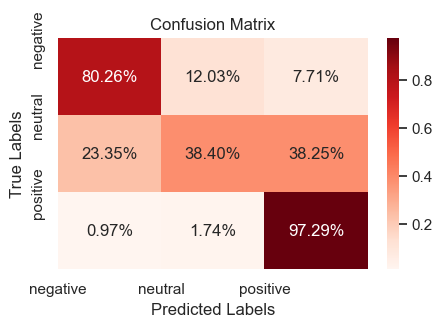

In [5]:
# Plot the confusion matrix using heatmap
sns.set(font_scale=1)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Reds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=range(len(class_labels)), labels=class_labels)
plt.yticks(ticks=range(len(class_labels)), labels=class_labels)
plt.title('Confusion Matrix')
plt.show()

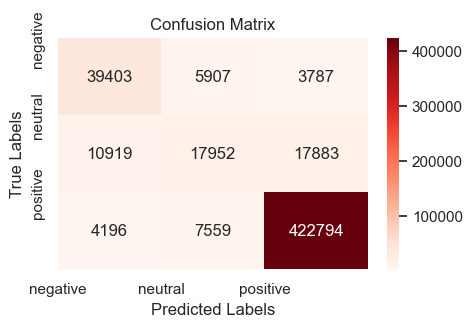

In [6]:
# Plot the confusion matrix using heatmap with count values
plt.figure(figsize=(5, 3))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=range(len(class_labels)), labels=class_labels)
plt.yticks(ticks=range(len(class_labels)), labels=class_labels)
plt.title('Confusion Matrix')
plt.show()

In [40]:
sdf.drop_duplicates(subset='Review', inplace=True)

### 5) FT DistilBERT Actual and Predicted Review Analysis
predicted negative actual positive & predictive positive actual negative

In [42]:
neg_pos = sdf[(sdf['predicted sentiment'] == 'negative') & (sdf['actual sentiment'] == 'positive')]['Review'].tolist()

In [54]:
for n in neg_pos[10:20]:
    print(n, '\n')

does not dry up the skin Will always be my fav cleanser!it did not dry up my combination-oily acne prone skin at all. bought together with fresh strawberry scrub cleanser(forgot its name). I gap 2days for the strawberry scrub, so far both work wonder on my skin. 

Returned item Didnt try it, returned it, dont remember why, I think it was due to it being scented. Utube Influencers say not to use scented stuff on your face as it causes sensitivity in the future. This still showed in my account as pending a review so here it is. 

UM IS THIS MAGIC? I got a sample of this and prior to this I was switching it around between cerave and panoxyl cleansers, however I swear as soon as I used this cleaner the small bumps on my forehead started to shrink! I immediately bought a full size! Smells a bit weird but honestly I don’t care because of the benefits of it! 

don't know bought this as a morning cleanser. have yet to try as I have not finish the opened one. the min 150 character is irritating

In [48]:
pos_neg = sdf[(sdf['predicted sentiment'] == 'positive') & (sdf['actual sentiment'] == 'negative')]['Review'].tolist()

In [49]:
print(len(pos_neg))

3454


In [56]:
for n in pos_neg[:10]:
    print(n, '\n')

alright ig Good for removing light makeup for really dry 

Sephora Collection Original Cleansing Face Wipes - Aloe Vera They are really dry!! They barely remove any makeup! 

just no I don’t know what happened to the old formula but, bring it back! Pleaseeee they were amazing . This new formula burns my face ! Super mad about it. I beg of you to bring the other formula back . 

The original wipes are so much better The original wipes are so much better than these “gentle” exfoliating wipes. The original wipes had tiny beads that would exfoliate quite nicely. These do NOT exfoliate. Fortunately it looks like they are still selling the original wipes so I bought 4 just in case. 

Sephora Collection Original Cleansing Face Wipes - Aloe Vera The papaya wipes were the best thing ever and are now no longer available. Please bring back the previous formulas and cloths! 

Sephora Collection Original Cleansing Face Wipes - Aloe Vera So bummed! These were the most amazing exfoliating wipes. They